In [1]:
import pandas as pd
#import ray.dataframe as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *

import lightgbm as lgb
import os
import gc
import pickle

In [2]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        'hourofday'     : 'uint8',
        'dayofweek'     : 'uint8',
        'ip_device_os'     : 'uint32',
        'ip_device_os_app'     : 'uint32',
        'ip_device_os_app_channel' : 'uint32',
        
        }

In [3]:
train = pd.read_csv("../input/train_base.csv", dtype=dtypes, skiprows=range(1,120*10**6), nrows=30* 10**6)
train.head()

,ip,app,device,os,channel,is_attributed,click_time,dayofweek,hourofday,ip_device_os,ip_device_os_app,ip_device_os_app_channel
0,53454,18,1,13,107,0,2017-11-08 15:19:33,2,15,2030562,15281242,60903495
1,95766,12,1,19,265,0,2017-11-08 15:19:33,2,15,2089086,6664161,43218990
2,44744,15,1,18,245,0,2017-11-08 15:19:33,2,15,2023985,14422182,52911397
3,29748,18,1,47,107,0,2017-11-08 15:19:33,2,15,2384319,19019190,6434270
4,71017,15,1,35,245,0,2017-11-08 15:19:33,2,15,1464977,42829,53949927


In [4]:
train.shape

(30000000, 12)

In [5]:
def plot_feature(df, col):
    sns.distplot(df.loc[df.is_attributed == 0, col])
    sns.distplot(df.loc[df.is_attributed == 1, col])
    plt.show()

In [6]:
def time_details(df):
    df['epoch_time'] = ((pd.to_datetime(df['click_time']) - pd.to_datetime("2017-11-06 14:00:00"))/10**9).astype(np.int64).astype(np.uint32)
    df['seconds'] = (df['epoch_time'] % 60).astype(np.uint8)
    df['epoch_minute'] = (df['epoch_time'] // 60).astype(np.uint32)
    df['minutes'] = (df['epoch_minute'] % 60).astype(np.uint8)
    
    #del df['click_time']
    return df

In [7]:
train = time_details(train)

In [8]:
train['hourofday'].value_counts()

4     4032691
3     3351149
0     3318301
1     3082862
2     3068887
16    2455567
23    2366694
15    2070802
17    1387383
22    1260525
5     1259156
18     794088
19     554053
21     550518
20     447324
Name: hourofday, dtype: int64

In [9]:
tr, val = train_test_split(train, test_size=0.2)
print(tr.shape, val.shape)

(24000000, 16) (6000000, 16)


In [10]:
tr.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'is_attributed', 'click_time',
       'dayofweek', 'hourofday', 'ip_device_os', 'ip_device_os_app',
       'ip_device_os_app_channel', 'epoch_time', 'seconds', 'epoch_minute',
       'minutes'],
      dtype='object')

In [13]:
feats = ['ip', 'app', 'device', 'os', 'channel', 'hourofday']

In [14]:
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, 
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats], tr['is_attributed'], eval_set=[(val[feats], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.918694
[20]	valid_0's auc: 0.918364
[30]	valid_0's auc: 0.933639
[40]	valid_0's auc: 0.951349
[50]	valid_0's auc: 0.956472
[60]	valid_0's auc: 0.957598
[70]	valid_0's auc: 0.959905
[80]	valid_0's auc: 0.961285
[90]	valid_0's auc: 0.962434
[100]	valid_0's auc: 0.96324
[110]	valid_0's auc: 0.963941
[120]	valid_0's auc: 0.964258
[130]	valid_0's auc: 0.964597
[140]	valid_0's auc: 0.965251
[150]	valid_0's auc: 0.965403
[160]	valid_0's auc: 0.965644
[170]	valid_0's auc: 0.965762
[180]	valid_0's auc: 0.96595
[190]	valid_0's auc: 0.966081
[200]	valid_0's auc: 0.966355
[210]	valid_0's auc: 0.966562
[220]	valid_0's auc: 0.966705
[230]	valid_0's auc: 0.966817
[240]	valid_0's auc: 0.966966
[250]	valid_0's auc: 0.967079
[260]	valid_0's auc: 0.967181
[270]	valid_0's auc: 0.967265
[280]	valid_0's auc: 0.967309
[290]	valid_0's auc: 0.96741
[300]	valid_0's auc: 0.96743
Did not meet early stopping. Best iteration is:
[3

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [21]:
scores = []
for f in ['minutes', 'seconds', 'ip_device_os', 'ip_device_os_app',
       'ip_device_os_app_channel']:
    feats2 = feats + [f]
    
    model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                               scale_pos_weight=9, 
                           num_leaves=15, n_jobs=16)
    model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
          verbose=10, early_stopping_rounds=100,)
    
    scores.append(roc_auc_score(val['is_attributed'], model.predict_proba(val[feats2])[:,1]))

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.920729
[20]	valid_0's auc: 0.927331
[30]	valid_0's auc: 0.944638
[40]	valid_0's auc: 0.949961
[50]	valid_0's auc: 0.955619
[60]	valid_0's auc: 0.958962
[70]	valid_0's auc: 0.960873
[80]	valid_0's auc: 0.961258
[90]	valid_0's auc: 0.96216
[100]	valid_0's auc: 0.962951
[110]	valid_0's auc: 0.963446
[120]	valid_0's auc: 0.963747
[130]	valid_0's auc: 0.964282
[140]	valid_0's auc: 0.964588
[150]	valid_0's auc: 0.964814
[160]	valid_0's auc: 0.965104
[170]	valid_0's auc: 0.965415
[180]	valid_0's auc: 0.965649
[190]	valid_0's auc: 0.965845
[200]	valid_0's auc: 0.966008
[210]	valid_0's auc: 0.966112
[220]	valid_0's auc: 0.966377
[230]	valid_0's auc: 0.96658
[240]	valid_0's auc: 0.966617
[250]	valid_0's auc: 0.966691
[260]	valid_0's auc: 0.966853
[270]	valid_0's auc: 0.966966
[280]	valid_0's auc: 0.967039
[290]	valid_0's auc: 0.967105
[300]	valid_0's auc: 0.967164
Did not meet early stopping. Best iteration is:


KeyboardInterrupt: 

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    A utlity class to help encode categorical variables using different methods.
    
    Inputs:
    cols: (List or str) Can be either a string or list of strings with column names
    targetcol: (str) Target column to encode column/group of columns with
    thresh: (int) Minimum count of grouping to encode (Acts as smoothing). Currently not implemented TODO
    func: (str or callable) Function to be applied on column/ group of columns to encode. 
          If str is provided, it should be a attribute of pandas Series
    cname: (str) Column name for new string
    func_kwargs: (dict) Additional arguments to be passed to function 
    add_to_orig: (bool) Whether to return dataframe with added feature or just the feature as series
    
    Output:
    pandas DataFrame/Series
    
    """
    def __init__(self, cols=None, targetcol=None, cname=None, thresh=0, func=np.mean,  add_to_orig=False,                              func_kwargs={}):
        self.cols = cols #Can be either a string or list of strings with column names
        self.targetcol = targetcol #Target column to encode column/group of columns with
        self.thresh = thresh  #Minimum count of grouping to encode (Acts as smoothing)
        self.func = func #Function to be applied on column/ group of columns to encode 
        self.add_to_orig = add_to_orig #Whether return a dataframe with added feature or just a series of feature
        self.cname = cname #Column to new feature generated
        self.func_kwargs = func_kwargs  #Additional key word arguments to be applied to func
    
    #@numba.jit        
    def fit(self, X, y=None):
            
        if isinstance(self.func, str):
            if hasattr(pd.Series, self.func):
                #print("here")
                vals = getattr(X.groupby(self.cols)[self.targetcol], self.func)
                self.dictmap = vals(**self.func_kwargs)
                
        else:
            self.dictmap = X.groupby(self.cols)[self.targetcol].apply(lambda x: self.func(x, **self.func_kwargs))
            
        if self.cname:
            self.dictmap.name = self.cname
        else:
            cname = ''
            cname = [cname + '_' +str(col) for col in self.cols]
            self.cname = '_'.join(cname) + "_" + str(self.func)
            self.dictmap.name = self.cname
            
        #print(self.cname)
        self.dictmap = self.dictmap
        return self
    
    #@numba.jit
    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_transformed = X[self.cols]
            
            X_transformed = X_transformed.join(self.dictmap, on=self.cols, how='left')[self.cname]

            if self.add_to_orig:
                return pd.concat([X, X_transformed], axis=1, copy=False)
            else:
                return X_transformed.values

        else:
            raise TypeError("Input should be a pandas DataFrame")

In [16]:
#Add mean feature
app_mean = TargetEncoder(cols=['app'],  targetcol='is_attributed', func='mean')
tr['app_mean'] = app_mean.fit_transform(tr[['app', 'is_attributed']])
val['app_mean'] = app_mean.transform(val[['app', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


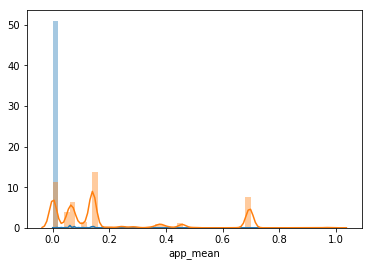

In [17]:
#plot_feature(tr, 'app_mean')

In [18]:
feats2 = feats + ['app_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, 
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)


Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954145
[20]	valid_0's auc: 0.955253
[30]	valid_0's auc: 0.956428
[40]	valid_0's auc: 0.959169
[50]	valid_0's auc: 0.96126
[60]	valid_0's auc: 0.962076
[70]	valid_0's auc: 0.96337
[80]	valid_0's auc: 0.964231
[90]	valid_0's auc: 0.96486
[100]	valid_0's auc: 0.965403
[110]	valid_0's auc: 0.965837
[120]	valid_0's auc: 0.966076
[130]	valid_0's auc: 0.966243
[140]	valid_0's auc: 0.966364
[150]	valid_0's auc: 0.966543
[160]	valid_0's auc: 0.966698
[170]	valid_0's auc: 0.966768
[180]	valid_0's auc: 0.966859
[190]	valid_0's auc: 0.966928
[200]	valid_0's auc: 0.967407
[210]	valid_0's auc: 0.967482
[220]	valid_0's auc: 0.96761
[230]	valid_0's auc: 0.967675
[240]	valid_0's auc: 0.967732
[250]	valid_0's auc: 0.967807
[260]	valid_0's auc: 0.967916
[270]	valid_0's auc: 0.967983
[280]	valid_0's auc: 0.968031
[290]	valid_0's auc: 0.968121
[300]	valid_0's auc: 0.968123
Did not meet early stopping. Best iteration is:
[2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [19]:
#Add channel feature
channel_mean = TargetEncoder(cols=['channel'],  targetcol='is_attributed', func='mean')
tr['channel_mean'] = channel_mean.fit_transform(tr[['channel', 'is_attributed']])
val['channel_mean'] = channel_mean.transform(val[['channel', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [20]:
feats2 = feats + ['app_mean', 'channel_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.958686
[20]	valid_0's auc: 0.960299
[30]	valid_0's auc: 0.961447
[40]	valid_0's auc: 0.961519
[50]	valid_0's auc: 0.963489
[60]	valid_0's auc: 0.964334
[70]	valid_0's auc: 0.965684
[80]	valid_0's auc: 0.96641
[90]	valid_0's auc: 0.967059
[100]	valid_0's auc: 0.96746
[110]	valid_0's auc: 0.967703
[120]	valid_0's auc: 0.967867
[130]	valid_0's auc: 0.968056
[140]	valid_0's auc: 0.968219
[150]	valid_0's auc: 0.968377
[160]	valid_0's auc: 0.968478
[170]	valid_0's auc: 0.968547
[180]	valid_0's auc: 0.968591
[190]	valid_0's auc: 0.968688
[200]	valid_0's auc: 0.968793
[210]	valid_0's auc: 0.968844
[220]	valid_0's auc: 0.968969
[230]	valid_0's auc: 0.969033
[240]	valid_0's auc: 0.969109
[250]	valid_0's auc: 0.969219
[260]	valid_0's auc: 0.969268
[270]	valid_0's auc: 0.969281
[280]	valid_0's auc: 0.969322
[290]	valid_0's auc: 0.969359
[300]	valid_0's auc: 0.969402
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [ ]:
#Add channel feature
ip_count = TargetEncoder(cols=['ip'],  targetcol='is_attributed', func='count')
tr['ip_count'] = ip_count.fit_transform(tr[['ip', 'is_attributed']])
val['ip_count'] = ip_count.transform(val[['ip', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.958081
[20]	valid_0's auc: 0.961951
[30]	valid_0's auc: 0.963255
[40]	valid_0's auc: 0.965941
[50]	valid_0's auc: 0.967342
[60]	valid_0's auc: 0.968394


In [ ]:
app_count = TargetEncoder(cols=['app'],  targetcol='is_attributed', func='count')
tr['app_count'] = app_count.fit_transform(tr[['app', 'is_attributed']])
val['app_count'] = app_count.transform(val[['app', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#High Pulse feature
ip_dayhourmin_count = TargetEncoder(cols=['ip', 'dayofweek', 'hourofday', 'epoch_minute'],  targetcol='is_attributed', func='count')
tr['ip_dayhourmin_count'] = ip_dayhourmin_count.fit_transform(tr[['ip', 'dayofweek', 'hourofday', 'epoch_minute', 'is_attributed']])
val['ip_dayhourmin_count'] = ip_dayhourmin_count.transform(val[['ip', 'dayofweek', 'hourofday', 'epoch_minute', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_dayhourmin_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#Ip device os clicks
ip_device_os_count = TargetEncoder(cols=['ip', 'device', 'os'],  targetcol='is_attributed', func='count')
tr['ip_device_os_count'] = ip_device_os_count.fit_transform(tr[['ip', 'device', 'os', 'is_attributed']])
val['ip_device_os_count'] = ip_device_os_count.transform(val[['ip', 'device', 'os', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#Mid Pulse feature
ip_dayhour_count = TargetEncoder(cols=['ip', 'dayofweek', 'hourofday'],  targetcol='is_attributed', func='count')
tr['ip_dayhour_count'] = ip_dayhour_count.fit_transform(tr[['ip', 'dayofweek', 'hourofday', 'is_attributed']])
val['ip_dayhour_count'] = ip_dayhour_count.transform(val[['ip', 'dayofweek', 'hourofday', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'ip_dayhour_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=1.0,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#Mid Pulse feature
device_os_count = TargetEncoder(cols=['device', 'os'],  targetcol='is_attributed', func='count')
tr['device_os_count'] = device_os_count.fit_transform(tr[['device', 'os', 'is_attributed']])
val['device_os_count'] = device_os_count.transform(val[['device', 'os', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#Mid Pulse feature
channel_count = TargetEncoder(cols=['channel'],  targetcol='is_attributed', func='count')
tr['channel_count'] = channel_count.fit_transform(tr[['channel', 'is_attributed']])
val['channel_count'] = channel_count.transform(val[['channel', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count', 'channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
ip_mean = TargetEncoder(cols=['ip'],  targetcol='is_attributed', func='mean')
tr['ip_mean'] = ip_mean.fit_transform(tr[['ip', 'is_attributed']])
val['ip_mean'] = ip_mean.transform(val[['ip', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'ip_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
gc.collect()

In [ ]:
device_mean = TargetEncoder(cols=['device'],  targetcol='is_attributed', func='mean')
tr['device_mean'] = device_mean.fit_transform(tr[['device', 'is_attributed']])
val['device_mean'] = device_mean.transform(val[['device', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'device_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
os_mean = TargetEncoder(cols=['os'],  targetcol='is_attributed', func='mean')
tr['os_mean'] = os_mean.fit_transform(tr[['os', 'is_attributed']])
val['os_mean'] = os_mean.transform(val[['os', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
#unique device os on ip
ip_unq_ip_device_os = TargetEncoder(cols=['ip'],  targetcol='ip_device_os', func='nunique')
tr['ip_unq_ip_device_os'] = ip_unq_ip_device_os.fit_transform(tr[['ip', 'ip_device_os']])
val['ip_unq_ip_device_os'] = ip_unq_ip_device_os.transform(val[['ip', 'ip_device_os']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
tr['user_click_ratio'] = tr['ip_unq_ip_device_os']/tr['ip_count']
val['user_click_ratio'] = val['ip_unq_ip_device_os']/val['ip_count']

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
ip_unq_app = TargetEncoder(cols=['ip'],  targetcol='app', func='nunique')
tr['ip_unq_app'] = ip_unq_app.fit_transform(tr[['ip', 'app']])
val['ip_unq_app'] = ip_unq_app.transform(val[['ip', 'app']])

In [ ]:
tr['app_click_ratio'] = tr['ip_unq_app']/tr['ip_count']
val['app_click_ratio'] = val['ip_unq_app']/val['ip_count']

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio', 'app_click_ratio', 'ip_unq_app']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
ip_device_os_app_count = TargetEncoder(cols=['ip_device_os_app'],  targetcol='app', func='count')
tr['ip_device_os_app_count'] = ip_device_os_app_count.fit_transform(tr[['ip_device_os_app', 'app']])
val['ip_device_os_app_count'] = ip_device_os_app_count.transform(val[['ip_device_os_app', 'app']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
ip_device_os_app_channel_count = TargetEncoder(cols=['ip_device_os_app_channel'],  targetcol='app', func='count')
tr['ip_device_os_app_channel_count'] = ip_device_os_app_channel_count.fit_transform(tr[['ip_device_os_app_channel', 'app']])
val['ip_device_os_app_channel_count'] = ip_device_os_app_channel_count.transform(val[['ip_device_os_app_channel', 'app']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [ ]:
ip_app_channel_count = TargetEncoder(cols=['ip', 'app', 'channel'],  targetcol='is_attributed', func='count')
tr['ip_app_channel_count'] = ip_app_channel_count.fit_transform(tr[['ip', 'app', 'channel', 'is_attributed']])
val['ip_app_channel_count'] = ip_app_channel_count.transform(val[['ip', 'app', 'channel', 'is_attributed']])

In [ ]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

In [80]:
col = ['ip_device_os']
target = 'epoch_time'
tot = pd.concat([tr[col + [target]], val[col + [target]]]).reset_index().sort_values(by=target)
n = len(tr)

tot['_'.join(col) + 'last_click'] = tot['epoch_time'] - tot.groupby(col)[target].shift()
tot['_'.join(col) + 'next_click'] = tot['epoch_time'] - tot.groupby(col)[target].shift(-1)

tr['_'.join(col) + 'last_click'] = tot.sort_index().loc[:n-1, '_'.join(col) + 'last_click']
tr['_'.join(col) + 'next_click'] = tot.sort_index().loc[:n-1, '_'.join(col) +'last_click']
val[ '_'.join(col) + 'last_click'] = tot.sort_index().loc[n:, '_'.join(col) + 'last_click']
val['_'.join(col) + 'next_click'] = tot.sort_index().loc[n:, '_'.join(col) + 'next_click']

del tot

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [81]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'last_click', 'next_click']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954336
[20]	valid_0's auc: 0.960643
[30]	valid_0's auc: 0.963022
[40]	valid_0's auc: 0.964362
[50]	valid_0's auc: 0.967133
[60]	valid_0's auc: 0.968799
[70]	valid_0's auc: 0.970068
[80]	valid_0's auc: 0.970354
[90]	valid_0's auc: 0.970914
[100]	valid_0's auc: 0.971503
[110]	valid_0's auc: 0.971652
[120]	valid_0's auc: 0.971901
[130]	valid_0's auc: 0.972093
[140]	valid_0's auc: 0.972267
[150]	valid_0's auc: 0.972323
[160]	valid_0's auc: 0.972505
[170]	valid_0's auc: 0.972525
[180]	valid_0's auc: 0.972532
[190]	valid_0's auc: 0.972618
[200]	valid_0's auc: 0.9726
[210]	valid_0's auc: 0.972467
[220]	valid_0's auc: 0.972486
[230]	valid_0's auc: 0.972507
[240]	valid_0's auc: 0.972536
[250]	valid_0's auc: 0.972561
[260]	valid_0's auc: 0.972621
[270]	valid_0's auc: 0.972658
[280]	valid_0's auc: 0.972694
[290]	valid_0's auc: 0.972761
[300]	valid_0's auc: 0.972765
Did not meet early stopping. Best iteration is:


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [83]:
ip_std_last_click = TargetEncoder(cols=['ip'],  targetcol='last_click', func='std')
tr['ip_std_last_click'] = ip_std_last_click.fit_transform(tr[['ip', 'last_click']])
val['ip_std_last_click'] = ip_std_last_click.transform(val[['ip', 'last_click']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'ip_std_last_click']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953888
[20]	valid_0's auc: 0.961523
[30]	valid_0's auc: 0.963094
[40]	valid_0's auc: 0.965777
[50]	valid_0's auc: 0.967493
[60]	valid_0's auc: 0.96903
[70]	valid_0's auc: 0.969894
[80]	valid_0's auc: 0.970541
[90]	valid_0's auc: 0.971102
[100]	valid_0's auc: 0.971562
[110]	valid_0's auc: 0.97177
[120]	valid_0's auc: 0.971924
[130]	valid_0's auc: 0.972091
[140]	valid_0's auc: 0.972263
[150]	valid_0's auc: 0.972484
[160]	valid_0's auc: 0.972701
[170]	valid_0's auc: 0.972755
[180]	valid_0's auc: 0.972786
[190]	valid_0's auc: 0.972903
[200]	valid_0's auc: 0.972761
[210]	valid_0's auc: 0.972805
[220]	valid_0's auc: 0.972773
[230]	valid_0's auc: 0.972648
[240]	valid_0's auc: 0.972555
[250]	valid_0's auc: 0.972591
[260]	valid_0's auc: 0.972624
[270]	valid_0's auc: 0.972609
[280]	valid_0's auc: 0.972672
[290]	valid_0's auc: 0.972669
Early stopping, best iteration is:
[191]	valid_0's auc: 0.972919


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [85]:
app_count_mean = TargetEncoder(cols=['app_count'],  targetcol='is_attributed', func='mean')
tr['app_count_mean'] = app_count_mean.fit_transform(tr[['app_count', 'is_attributed']])
val['app_count_mean'] = app_count_mean.transform(val[['app_count', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'app_count_mean']
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.953866
[20]	valid_0's auc: 0.9626
[30]	valid_0's auc: 0.963651
[40]	valid_0's auc: 0.966413
[50]	valid_0's auc: 0.967452
[60]	valid_0's auc: 0.969049
[70]	valid_0's auc: 0.970027
[80]	valid_0's auc: 0.970662
[90]	valid_0's auc: 0.971189
[100]	valid_0's auc: 0.97169
[110]	valid_0's auc: 0.971917
[120]	valid_0's auc: 0.972153
[130]	valid_0's auc: 0.972409
[140]	valid_0's auc: 0.972603
[150]	valid_0's auc: 0.97254
[160]	valid_0's auc: 0.972549
[170]	valid_0's auc: 0.972666
[180]	valid_0's auc: 0.972682
[190]	valid_0's auc: 0.97274
[200]	valid_0's auc: 0.972713
[210]	valid_0's auc: 0.972759
[220]	valid_0's auc: 0.972727
[230]	valid_0's auc: 0.972735
[240]	valid_0's auc: 0.972771
[250]	valid_0's auc: 0.972791
[260]	valid_0's auc: 0.972844
[270]	valid_0's auc: 0.972897
[280]	valid_0's auc: 0.97288
[290]	valid_0's auc: 0.972892
[300]	valid_0's auc: 0.972865
Did not meet early stopping. Best iteration is:
[278

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0,
        scale_pos_weight=9, silent=True, subsample=0.7,
        subsample_for_bin=200000, subsample_freq=1)

In [87]:
ip_count_mean = TargetEncoder(cols=['ip_count'],  targetcol='is_attributed', func='mean')
tr['ip_count_mean'] = ip_count_mean.fit_transform(tr[['ip_count', 'is_attributed']])
val['ip_count_mean'] = ip_count_mean.transform(val[['ip_count', 'is_attributed']])

/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/mohsin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [89]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  ]
model = lgb.LGBMClassifier(n_estimators=300, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500, reg_lambda = 1,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.95908
[20]	valid_0's auc: 0.964752
[30]	valid_0's auc: 0.964579
[40]	valid_0's auc: 0.965075
[50]	valid_0's auc: 0.967317
[60]	valid_0's auc: 0.968788
[70]	valid_0's auc: 0.969959
[80]	valid_0's auc: 0.970476
[90]	valid_0's auc: 0.97104
[100]	valid_0's auc: 0.971616
[110]	valid_0's auc: 0.971881
[120]	valid_0's auc: 0.972071
[130]	valid_0's auc: 0.972302
[140]	valid_0's auc: 0.97244
[150]	valid_0's auc: 0.97262
[160]	valid_0's auc: 0.972778
[170]	valid_0's auc: 0.972858
[180]	valid_0's auc: 0.972895
[190]	valid_0's auc: 0.972978
[200]	valid_0's auc: 0.972984
[210]	valid_0's auc: 0.972969
[220]	valid_0's auc: 0.973028
[230]	valid_0's auc: 0.973099
[240]	valid_0's auc: 0.973191
[250]	valid_0's auc: 0.973228
[260]	valid_0's auc: 0.973271
[270]	valid_0's auc: 0.973223
[280]	valid_0's auc: 0.973261
[290]	valid_0's auc: 0.973303
[300]	valid_0's auc: 0.973322
Did not meet early stopping. Best iteration is:
[2

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=300, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=9,
        silent=True, subsample=0.7, subsample_for_bin=200000,
        subsample_freq=1)

In [90]:
feats2 = feats + ['app_mean', 'channel_mean', 'ip_count', 'app_count', 'ip_device_os_count', 'device_os_count',
                  'channel_count', 'os_mean', 'ip_unq_ip_device_os', 'user_click_ratio',
                  'ip_device_os_app_count', 'ip_device_os_app_channel_count', 'ip_app_channel_count',
                  'minutes', 'seconds']
model = lgb.LGBMClassifier(n_estimators=1000, max_depth=4, subsample=0.7, colsample_bytree=0.7, colsample_bylevel=0.7,
                           scale_pos_weight=9, min_child_samples=500, reg_lambda = 1,
                       num_leaves=15, n_jobs=-1)
model.fit( tr[feats2], tr['is_attributed'], eval_set=[(val[feats2], val['is_attributed'])], eval_metric='auc', 
      verbose=10, early_stopping_rounds=100,)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.954336
[20]	valid_0's auc: 0.960643
[30]	valid_0's auc: 0.963023
[40]	valid_0's auc: 0.96436
[50]	valid_0's auc: 0.967115
[60]	valid_0's auc: 0.968743
[70]	valid_0's auc: 0.96995
[80]	valid_0's auc: 0.970416
[90]	valid_0's auc: 0.971224
[100]	valid_0's auc: 0.971627
[110]	valid_0's auc: 0.971877
[120]	valid_0's auc: 0.972064
[130]	valid_0's auc: 0.972288
[140]	valid_0's auc: 0.97244
[150]	valid_0's auc: 0.972595
[160]	valid_0's auc: 0.972692
[170]	valid_0's auc: 0.97279
[180]	valid_0's auc: 0.972814
[190]	valid_0's auc: 0.972901
[200]	valid_0's auc: 0.972964
[210]	valid_0's auc: 0.972947
[220]	valid_0's auc: 0.972982
[230]	valid_0's auc: 0.973031
[240]	valid_0's auc: 0.973022
[250]	valid_0's auc: 0.972982
[260]	valid_0's auc: 0.973052
[270]	valid_0's auc: 0.973088
[280]	valid_0's auc: 0.973128
[290]	valid_0's auc: 0.973108
[300]	valid_0's auc: 0.973058
[310]	valid_0's auc: 0.973085
[320]	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bylevel=0.7,
        colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
        min_child_samples=500, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=1000, n_jobs=-1, num_leaves=15, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=1, scale_pos_weight=9,
        silent=True, subsample=0.7, subsample_for_bin=200000,
        subsample_freq=1)